In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms, datasets

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
def count_folders_and_files(root_dir):
    class_folders = [d for d in os.listdir(root_dir)]
    print(f"\n📁 In directory: {root_dir}")
    print(f"Number of class folders: {len(class_folders)}")

    total_images = 0
    for class_name in class_folders:
        class_dir = os.path.join(root_dir, class_name)
        num_images = len([f for f in os.listdir(class_dir)])
        total_images += num_images

    print(f"Total images in {root_dir}: {total_images}")

In [3]:
train_dir = os.path.join("/kaggle/input/chest-xray-pneumonia/chest_xray", "train")
val_dir = os.path.join("/kaggle/input/chest-xray-pneumonia/chest_xray", "val")
test_dir = os.path.join("/kaggle/input/chest-xray-pneumonia/chest_xray", "test")

In [4]:
count_folders_and_files(train_dir)
count_folders_and_files(val_dir)
count_folders_and_files(test_dir)


📁 In directory: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Number of class folders: 2
Total images in /kaggle/input/chest-xray-pneumonia/chest_xray/train: 5216

📁 In directory: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Number of class folders: 2
Total images in /kaggle/input/chest-xray-pneumonia/chest_xray/val: 16

📁 In directory: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Number of class folders: 2
Total images in /kaggle/input/chest-xray-pneumonia/chest_xray/test: 624


In [5]:
mean = [0.5]*3
std  = [0.25]*3


train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = val_transform


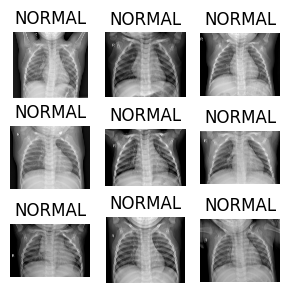

In [6]:
raw_train_data = ImageFolder(train_dir)

# Plot a few images
def plot_raw_images(dataset, figsize=(3, 3)):
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    for i in range(9):
        img, label = dataset[i]
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_raw_images(raw_train_data)


In [7]:
train_data = ImageFolder(train_dir, transform=train_transform)
val_data = ImageFolder(val_dir, transform=val_transform)
test_data = ImageFolder(test_dir,transform=test_transform)

In [8]:
train_indices, val_indices = train_test_split(
    range(len(train_data)),
    test_size=0.2,  # 20% for validation
    stratify=[label for _, label in train_data],  # Maintain class distribution
    random_state=42  
)

# 3. Create samplers for training and validation
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# 4. Create data loaders using the samplers
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    sampler=train_sampler,
    num_workers=4
)




val_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    sampler=val_sampler,
    num_workers=4
)


test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,  
    num_workers=4
)

In [9]:
next(iter(train_loader))[0].shape,next(iter(val_loader))[0].shape,next(iter(test_loader))[0].shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([32, 3, 224, 224]),
 torch.Size([32, 3, 224, 224]))

In [10]:
labels = [label for _, label in train_data]
unique_classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model with transfer learning
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),  
    nn.Linear(model.classifier.in_features, 1)
)
model = model.to(device)

# Loss function with class weights for imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[1]/class_weights[0]]).to(device))

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Training parameters
epochs = 25
best_val_f1 = 0.0
patience = 7  # For early stopping
patience_counter = 0
best_model_wts = None

# Metrics tracking
train_losses = []
val_accuracies = []
val_f1_scores = []

# Training loop with improvements
for epoch in range(epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0
    all_labels = []
    all_predictions = []
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        
        # Store predictions and labels for metrics
        preds = torch.sigmoid(outputs) > 0.5
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())
    
    # Calculate training metrics
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    val_labels = []
    val_preds = []
    val_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            
            # Statistics
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            # Store for metrics calculation
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())
    
    # Calculate validation metrics
    val_accuracy = 100 * val_correct / val_total
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        np.array(val_labels), np.array(val_preds), average='binary'
    )
    val_auc = roc_auc_score(np.array(val_labels), np.array(val_probs))
    
    # Track metrics
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    # Update learning rate based on F1 score
    scheduler.step(val_f1)
    
    # Print results
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} completed in {elapsed_time:.2f}s")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation - Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
    
    # Save best model based on F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
        
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_accuracy': val_accuracy,
        }, 'best_model.pth')
        print(f"New best model saved with F1 score: {val_f1:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model for testing
print(f"Loading best model with validation F1: {best_val_f1:.4f}")
model.load_state_dict(best_model_wts)

# Evaluate on test set
model.eval()
test_correct, test_total = 0, 0
test_labels = []
test_preds = []
test_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Forward pass
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        
        # Statistics
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        
        # Store for metrics calculation
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())


Using device: cuda


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s]
Epoch 1/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.25it/s]


Epoch 1/25 completed in 57.69s
Train Loss: 0.1991
Validation - Accuracy: 69.83%, Precision: 0.9915, Recall: 0.5992, F1: 0.7470, AUC: 0.9340
New best model saved with F1 score: 0.7470


Epoch 2/25 [Val]: 100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch 2/25 completed in 57.15s
Train Loss: 0.1624
Validation - Accuracy: 79.60%, Precision: 0.9812, Recall: 0.7397, F1: 0.8435, AUC: 0.9404
New best model saved with F1 score: 0.8435


Epoch 3/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.22it/s]


Epoch 3/25 completed in 58.56s
Train Loss: 0.1509
Validation - Accuracy: 85.73%, Precision: 0.9845, Recall: 0.8209, F1: 0.8953, AUC: 0.9637
New best model saved with F1 score: 0.8953


Epoch 4/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.17it/s]


Epoch 4/25 completed in 58.40s
Train Loss: 0.1421
Validation - Accuracy: 92.34%, Precision: 0.9318, Recall: 0.9678, F1: 0.9494, AUC: 0.9703
New best model saved with F1 score: 0.9494


Epoch 5/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.13it/s]


Epoch 5/25 completed in 59.49s
Train Loss: 0.1363
Validation - Accuracy: 84.87%, Precision: 0.9858, Recall: 0.8080, F1: 0.8881, AUC: 0.9565


Epoch 6/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.17it/s]


Epoch 6/25 completed in 58.54s
Train Loss: 0.1318
Validation - Accuracy: 90.52%, Precision: 0.9301, Recall: 0.9433, F1: 0.9367, AUC: 0.9500


Epoch 7/25 [Val]: 100%|██████████| 33/33 [00:11<00:00,  2.98it/s]


Epoch 7/25 completed in 58.98s
Train Loss: 0.1240
Validation - Accuracy: 91.48%, Precision: 0.9236, Recall: 0.9652, F1: 0.9439, AUC: 0.9670


Epoch 8/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


Epoch 8/25 completed in 58.70s
Train Loss: 0.1197
Validation - Accuracy: 63.03%, Precision: 0.9974, Recall: 0.5039, F1: 0.6695, AUC: 0.9725


Epoch 9/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.05it/s]


Epoch 9/25 completed in 58.87s
Train Loss: 0.1106
Validation - Accuracy: 92.82%, Precision: 0.9343, Recall: 0.9716, F1: 0.9526, AUC: 0.9780
New best model saved with F1 score: 0.9526


Epoch 10/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.12it/s]


Epoch 10/25 completed in 59.61s
Train Loss: 0.1030
Validation - Accuracy: 93.30%, Precision: 0.9849, Recall: 0.9240, F1: 0.9535, AUC: 0.9784
New best model saved with F1 score: 0.9535


Epoch 11/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.13it/s]


Epoch 11/25 completed in 58.40s
Train Loss: 0.0938
Validation - Accuracy: 91.76%, Precision: 0.9873, Recall: 0.9008, F1: 0.9420, AUC: 0.9839


Epoch 12/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.11it/s]


Epoch 12/25 completed in 58.45s
Train Loss: 0.1014
Validation - Accuracy: 95.21%, Precision: 0.9702, Recall: 0.9652, F1: 0.9677, AUC: 0.9851
New best model saved with F1 score: 0.9677


Epoch 13/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.12it/s]


Epoch 13/25 completed in 58.46s
Train Loss: 0.0994
Validation - Accuracy: 90.61%, Precision: 0.9899, Recall: 0.8827, F1: 0.9332, AUC: 0.9860


Epoch 14/25 [Val]: 100%|██████████| 33/33 [00:11<00:00,  3.00it/s]


Epoch 14/25 completed in 58.93s
Train Loss: 0.0938
Validation - Accuracy: 92.05%, Precision: 0.9779, Recall: 0.9137, F1: 0.9447, AUC: 0.9797


Epoch 15/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


Epoch 15/25 completed in 58.41s
Train Loss: 0.0899
Validation - Accuracy: 84.48%, Precision: 0.9936, Recall: 0.7964, F1: 0.8841, AUC: 0.9798


Epoch 16/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.19it/s]


Epoch 16/25 completed in 59.02s
Train Loss: 0.0974
Validation - Accuracy: 90.04%, Precision: 0.9927, Recall: 0.8724, F1: 0.9287, AUC: 0.9839


Epoch 17/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


Epoch 17/25 completed in 58.74s
Train Loss: 0.0912
Validation - Accuracy: 93.01%, Precision: 0.9902, Recall: 0.9149, F1: 0.9511, AUC: 0.9886


Epoch 18/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.21it/s]


Epoch 18/25 completed in 58.36s
Train Loss: 0.0786
Validation - Accuracy: 91.28%, Precision: 0.9914, Recall: 0.8905, F1: 0.9382, AUC: 0.9881


Epoch 19/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.10it/s]


Epoch 19/25 completed in 58.69s
Train Loss: 0.0789
Validation - Accuracy: 95.88%, Precision: 0.9681, Recall: 0.9768, F1: 0.9724, AUC: 0.9903
New best model saved with F1 score: 0.9724


Epoch 20/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


Epoch 20/25 completed in 58.71s
Train Loss: 0.0662
Validation - Accuracy: 93.10%, Precision: 0.9862, Recall: 0.9201, F1: 0.9520, AUC: 0.9865


Epoch 21/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.15it/s]


Epoch 21/25 completed in 58.49s
Train Loss: 0.0727
Validation - Accuracy: 95.02%, Precision: 0.9763, Recall: 0.9562, F1: 0.9661, AUC: 0.9884


Epoch 22/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.20it/s]


Epoch 22/25 completed in 58.37s
Train Loss: 0.0740
Validation - Accuracy: 92.82%, Precision: 0.9902, Recall: 0.9124, F1: 0.9497, AUC: 0.9877


Epoch 23/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.19it/s]


Epoch 23/25 completed in 58.32s
Train Loss: 0.0759
Validation - Accuracy: 92.62%, Precision: 0.9847, Recall: 0.9149, F1: 0.9486, AUC: 0.9842


Epoch 24/25 [Val]: 100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


Epoch 24/25 completed in 59.38s
Train Loss: 0.0696
Validation - Accuracy: 94.92%, Precision: 0.9814, Recall: 0.9497, F1: 0.9653, AUC: 0.9919


Epoch 25/25 [Val]: 100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


Epoch 25/25 completed in 58.66s
Train Loss: 0.0640
Validation - Accuracy: 94.64%, Precision: 0.9959, Recall: 0.9317, F1: 0.9627, AUC: 0.9933
Loading best model with validation F1: 0.9724


Testing: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]



Test Results:
Accuracy: 92.63%
Precision: 0.8981
Recall: 0.9949
F1 Score: 0.9440
AUC-ROC: 0.9825


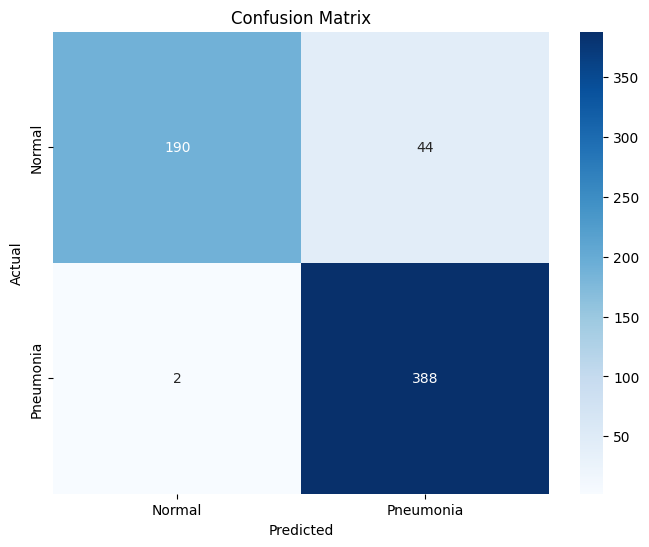

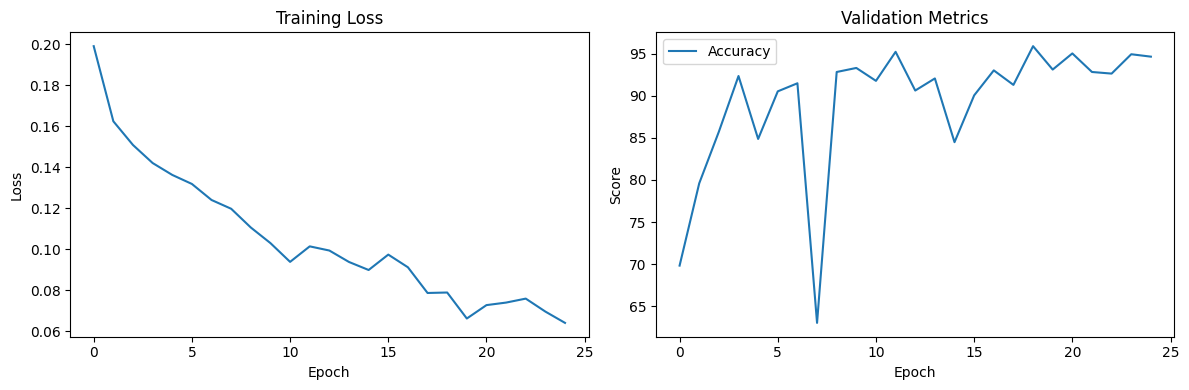

Model evaluation complete. Best model saved as 'best_model.pth'


In [11]:
# Calculate test metrics
test_accuracy = 100 * test_correct / test_total
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    np.array(test_labels), np.array(test_preds), average='binary'
)
test_auc = roc_auc_score(np.array(test_labels), np.array(test_probs))

print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")

# Create and plot confusion matrix
cm = confusion_matrix(np.array(test_labels), np.array(test_preds))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Accuracy')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

print("Model evaluation complete. Best model saved as 'best_model.pth'")